In [1]:
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string

plt.style.use("fivethirtyeight")
plt.rcParams["lines.linewidth"] = 1.5
dark_style = {
    "figure.facecolor": "#212946",
    "axes.facecolor": "#212946",
    "savefig.facecolor": "#212946",
    "axes.grid": True,
    "axes.grid.which": "both",
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "grid.color": "#2A3459",
    "grid.linewidth": "1",
    "text.color": "0.9",
    "axes.labelcolor": "0.9",
    "xtick.color": "0.9",
    "ytick.color": "0.9",
    "font.size": 12,
}
plt.rcParams.update(dark_style)

rcParams["figure.figsize"] = (18, 7)

# Load dataset
data = pd.read_csv('amazon_cells_labelled.txt', sep='\t', header=None, names=['sentence', 'score'])

# Check for unusual characters
def find_unusual_characters(text):
    return re.findall(r'[^a-zA-Z0-9\s,.!?\'\"-]', text)

In [2]:
# B1.  Perform exploratory data analysis on the chosen data set, and include an explanation of each of the following elements
# presence of unusual characters (e.g., emojis, non-English characters)
# vocabulary size
# proposed word embedding length
# statistical justification for the chosen maximum sequence length

# - presence of unusual characters (e.g., emojis, non-English characters)
data['unusual_chars'] = data['sentence'].apply(find_unusual_characters)
unusual_chars = data['unusual_chars'].explode().unique()
print("Unusual characters found:", unusual_chars)

# - vocabulary size
all_words = ' '.join(data['sentence']).split()
vocab_size = len(set(all_words))
print("Vocabulary size:", vocab_size)

# - statistical justification for the chosen maximum sequence length
review_lengths = data['sentence'].apply(lambda x: len(x.split()))
max_seq_length = int(np.percentile(review_lengths, 95))  # 95th percentile
print("Maximum sequence length:", max_seq_length)

Unusual characters found: [nan '+' '/' ':' ')' '(' '&' '$' '*' ';' '%' '#' '[' ']']
Vocabulary size: 2815
Maximum sequence length: 23


In [3]:
# B2.  Describe the goals of the tokenization process, including any code generated and packages that are used to normalize text during the tokenization process.
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def tokenize_and_normalize(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in stop_words and word not in punctuation]
    return tokens

data['tokens'] = data['sentence'].apply(tokenize_and_normalize)


max_seq_length = 23 # Determined from EDA
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['tokens'])
sequences = tokenizer.texts_to_sequences(data['tokens'])

In [4]:
# B3.  Explain the padding process used to standardize the length of sequences. Include the following in your explanation:
# if the padding occurs before or after the text sequence
# a screenshot of a single padded sequence

padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
print("Padded sequence example:", padded_sequences[0])

Padded sequence example: [137  87 442 443 159 695   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]


In [5]:
# B5.  Explain the steps used to prepare the data for analysis, including the size of the training, validation, and test set split (based on the industry average).

X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, data['score'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Training set size: 800
Validation set size: 100
Test set size: 100


In [6]:
# B6.  Provide a copy of the prepared data set.

# Saving padded_sequences to a CSV file
pd.DataFrame(padded_sequences).to_csv('padded_sequences.csv', index=False)

# Saving X_train, X_test, and X_val to CSV files
pd.DataFrame(X_train).to_csv('X_train.csv', index=False)
pd.DataFrame(X_test).to_csv('X_test.csv', index=False)
pd.DataFrame(X_val).to_csv('X_val.csv', index=False)

# Saving y_train, y_test, and y_val to CSV files
pd.DataFrame(y_train, columns=['y_train']).to_csv('y_train.csv', index=False)
pd.DataFrame(y_test, columns=['y_test']).to_csv('y_test.csv', index=False)
pd.DataFrame(y_val, columns=['y_val']).to_csv('y_val.csv', index=False)

In [12]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_seq_length),
    LSTM(100, return_sequences=True),
    Dropout(0.5),
    LSTM(100),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), callbacks=[early_stopping])
model.summary()

C:\Users\Eric\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.5122 - loss: 0.6936 - val_accuracy: 0.5700 - val_loss: 0.6897
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5254 - loss: 0.6865 - val_accuracy: 0.7600 - val_loss: 0.4854
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9057 - loss: 0.2969 - val_accuracy: 0.7700 - val_loss: 0.5375
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9487 - loss: 0.1660 - val_accuracy: 0.8100 - val_loss: 0.7660


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (32, 23, 100)               │         281,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (32, 23, 100)               │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (32, 23, 100)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (32, 100)                   │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 1)                     │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,327,205 (5.06 MB)

 Trainable params: 442,401 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 884,804 (3.38 MB)

In [13]:
# D1.  Discuss the impact of using stopping criteria to include defining the number of epochs, including a screenshot showing the final training epoch.
final_epoch = len(history.history['loss'])
print("Training stopped after {} epochs.".format(final_epoch))

Training stopped after 4 epochs.


In [9]:
# D2.  Assess the fitness of the model and any actions taken to address overfitting.

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8075 - loss: 0.4686 
Test Accuracy: 0.800000011920929
Test Loss: 0.472416490316391


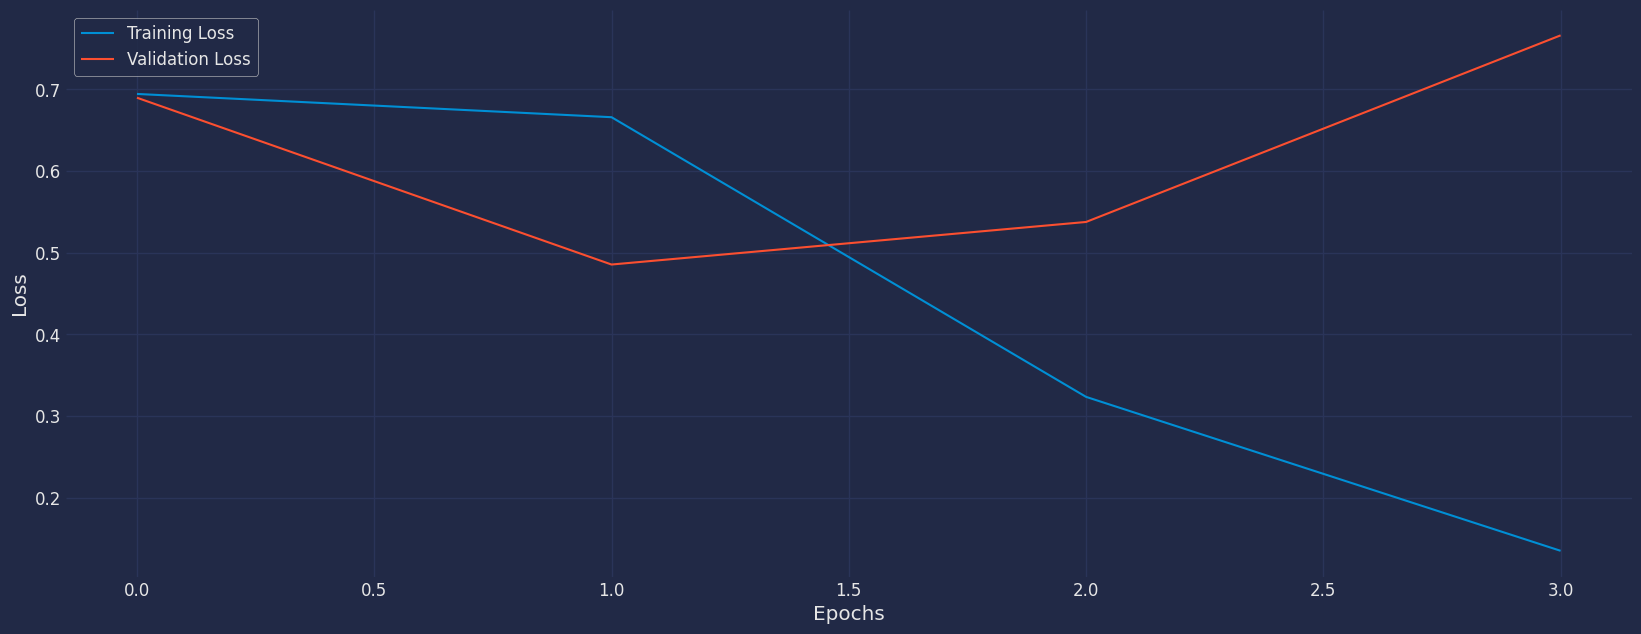

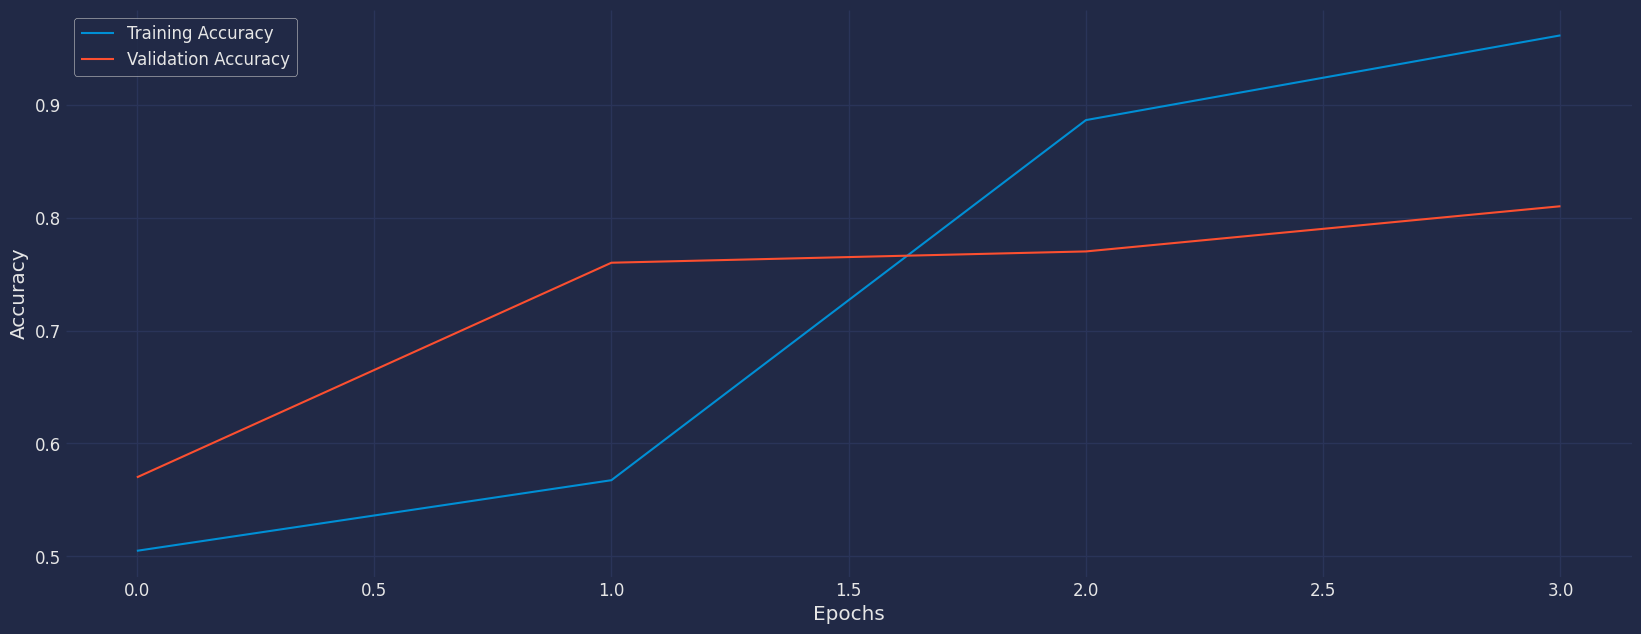

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8169 - loss: 0.4350 


Test Accuracy: 0.800000011920929


In [14]:
# D3.  Provide visualizations of the model’s training process, including a line graph of the loss and chosen evaluation metric.

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

model.save('sentiment_analysis_model.h5')

In [15]:
# F.  Discuss the functionality of your neural network, including the impact of the network architecture.
reviews = [
    "Absolutely love this product! It works wonders.",
    "Worst purchase ever, completely disappointed.",
    "Pretty decent, but I've seen better.",
    "An amazing buy, very satisfied with the quality!",
    "Did not meet my expectations at all.",
    "Okay product, not what I was hoping for.",
    "Incredible performance and great value for money.",
    "Not worth the price at all.",
    "Could be improved, lacks some important features.",
    "Best product I've used in years!",
    "Total waste of money, do not recommend.",
    "Fairly good, could be cheaper though.",
    "Love it! It’s exactly what I needed.",
    "Broke after one use, not durable.",
    "Surprisingly good for the price point."
]

# Assuming 'tokenizer' and 'max_seq_length' are loaded or defined elsewhere as they were during model training
tokens = [tokenize_and_normalize(review) for review in reviews]  # Use the same normalization function from your training
sequences = tokenizer.texts_to_sequences(tokens)
padded = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

# Predict sentiments
predictions = model.predict(padded)
predicted_sentiment = ['Positive' if pred > 0.5 else 'Negative' for pred in predictions.flatten()]

# Output
results = pd.DataFrame({
    'Review': reviews,
    'Sentiment': predicted_sentiment
})

print(results)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
                                               Review Sentiment
0     Absolutely love this product! It works wonders.  Positive
1       Worst purchase ever, completely disappointed.  Negative
2                Pretty decent, but I've seen better.  Positive
3    An amazing buy, very satisfied with the quality!  Positive
4                Did not meet my expectations at all.  Negative
5            Okay product, not what I was hoping for.  Positive
6   Incredible performance and great value for money.  Positive
7                         Not worth the price at all.  Positive
8   Could be improved, lacks some important features.  Negative
9                    Best product I've used in years!  Positive
10            Total waste of money, do not recommend.  Negative
11              Fairly good, could be cheaper though.  Positive
12               Love it! It’s exactly what I needed.  Positive
13                  Broke after one use, not durable.  Negative
1